In [50]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import re
from collections import Counter
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import emoji

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv('cyberbullying_tweets.csv')
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [4]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
# Check for missing values
df.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [7]:
# Check for duplicates
df.duplicated().sum()

36

In [8]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [9]:
# Lower case
def lower_case(text):
    return text.lower()

In [10]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
# Remove punctuations
punc = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', punc))

In [14]:
# Remove HTML_tags
def remove_html_tags(text):
    return re.sub(r"<.*?>", "", text)

In [15]:
# Replace emoji with string
def replace_emoji(text):
    repl = emoji.demojize(text)
    return repl

In [16]:
replace_emoji('Pythin is 🌱')

'Pythin is :seedling:'

In [17]:
# Stemming
ps = PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [18]:
# Preprocessing function
def transform_text(text):
    text = text.lower()
    text = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = emoji.demojize(text)
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for j in text:
        if j not in stopwords.words('english') and j not in string.punctuation:
            y.append(j)
            
    text = y[:]
    y.clear()
    
    for k in text:
        y.append(ps.stem(k))
        
    return " ".join(y)

In [19]:
df['transformed_text'] = df['tweet_text'].apply(transform_text)
df.head()

,tweet_text,cyberbullying_type,transformed_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,xochitlsuckkk classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,rudhoeenglish isi account pretend kurdish acco...


Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Distribution of target feature')

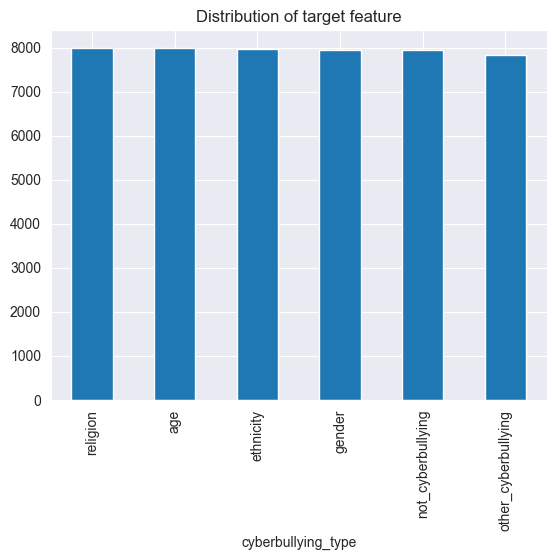

In [20]:
# Target feature
df['cyberbullying_type'].value_counts().plot(kind='bar')
plt.title('Distribution of target feature')

In [21]:
df['tweet_characters'] = df['tweet_text'].apply(len)
df['tweet_words'] = df['tweet_text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['tweet_sentences'] = df['tweet_text'].apply(lambda x: len(nltk.sent_tokenize(x)))

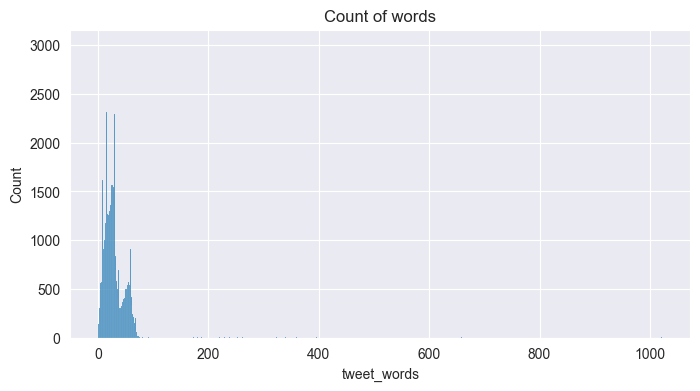

In [22]:
# Word Counts
plt.figure(figsize=(8,4))
sns.histplot(x=df['tweet_words'])
plt.title("Count of words")
plt.show()

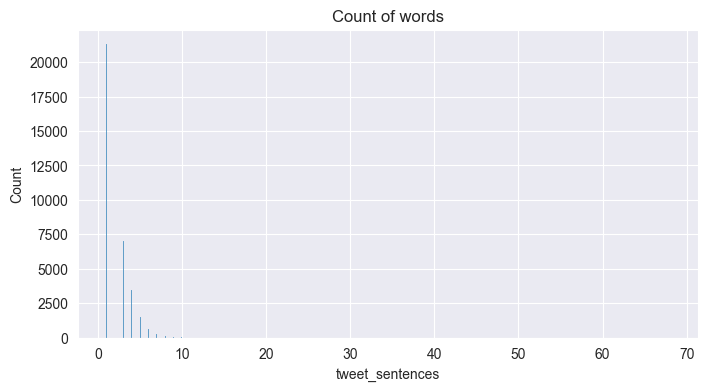

In [23]:
# Sentences Counts
plt.figure(figsize=(8,4))
sns.histplot(x=df['tweet_sentences'])
plt.title("Count of words")
plt.show()

In [24]:
df[df['cyberbullying_type']=='not_cyberbullying'].describe()

,tweet_characters,tweet_words,tweet_sentences
count,7937.000000,7937.000000,7937.000000
mean,83.085675,17.660451,1.668893
std,45.519168,9.566142,0.903751
min,2.000000,1.000000,1.000000
25%,49.000000,11.000000,1.000000
50%,81.000000,17.000000,1.000000
75%,119.000000,24.000000,2.000000
max,1809.000000,359.000000,21.000000


In [25]:
tweet_mean_values = df.groupby(by='cyberbullying_type').mean(numeric_only=True).reset_index()
tweet_mean_values

,cyberbullying_type,tweet_characters,tweet_words,tweet_sentences
0,age,173.542042,37.041166,2.143769
1,ethnicity,139.302928,30.388240,2.068853
2,gender,136.502139,29.298188,1.997609
3,not_cyberbullying,83.085675,17.660451,1.668893
4,other_cyberbullying,85.713281,18.408411,1.778602
5,religion,197.982243,39.584469,2.623609


In [26]:
gender_corpus = []
for text in df[df['cyberbullying_type']=='gender']['transformed_text'].tolist():
    
    for word in text.split():
        gender_corpus.append(word)
        
gender_common_words = pd.DataFrame(Counter(gender_corpus).most_common(30), columns=['words', 'counts'])

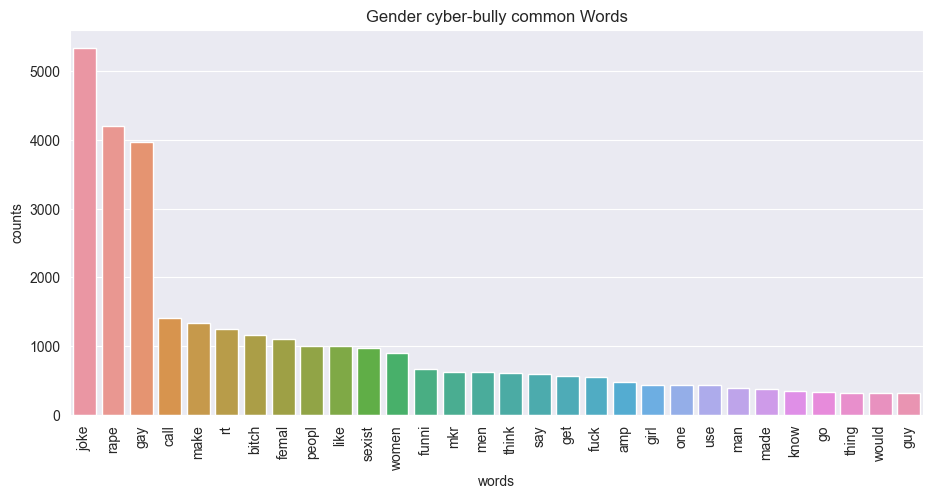

In [27]:
plt.figure(figsize=(11,5))
sns.barplot(x='words', y='counts', data=gender_common_words)
plt.title("Gender cyber-bully common Words")
plt.xticks(rotation=90)
plt.show()

In [28]:
# Word_cloud
wc = WordCloud(width=800, height=500, background_color='black', min_font_size=10)

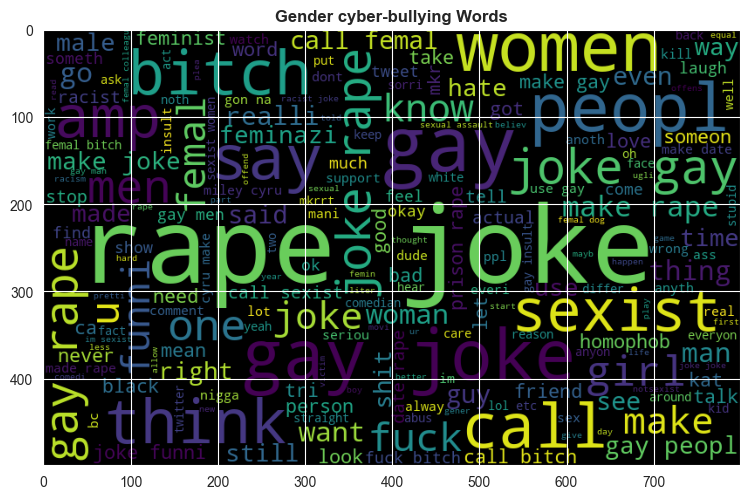

In [29]:
gender_wordcloud = wc.generate(df[df['cyberbullying_type']=='gender']['transformed_text'].str.cat(sep=""))
plt.figure(figsize=(9,7))
plt.imshow(gender_wordcloud)
plt.title("Gender cyber-bullying Words", fontweight='bold')
plt.show()

In [30]:
religion_corpus = []
for text in df[df['cyberbullying_type']=='religion']['transformed_text'].tolist():
    
    for word in text.split():
        religion_corpus.append(word)
        
religion_common_words = pd.DataFrame(Counter(religion_corpus).most_common(30), columns=['words', 'counts'])

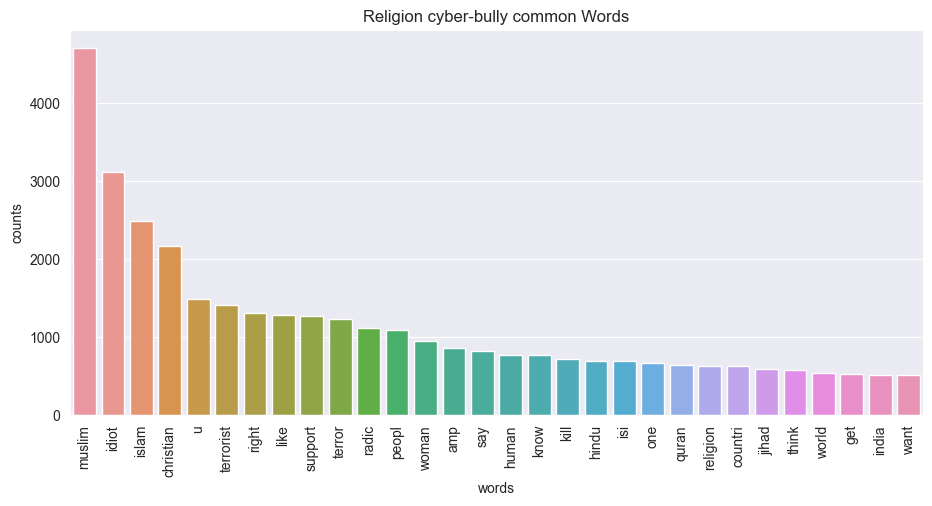

In [31]:
plt.figure(figsize=(11,5))
sns.barplot(x='words', y='counts', data=religion_common_words)
plt.title("Religion cyber-bully common Words")
plt.xticks(rotation=90)
plt.show()

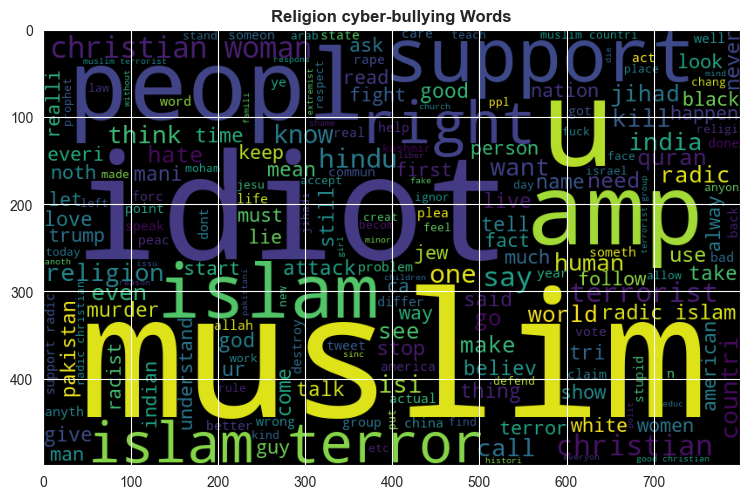

In [32]:
religion_wordcloud = wc.generate(df[df['cyberbullying_type']=='religion']['transformed_text'].str.cat(sep=""))
plt.figure(figsize=(9,7))
plt.imshow(religion_wordcloud)
plt.title("Religion cyber-bullying Words", fontweight='bold')
plt.show()

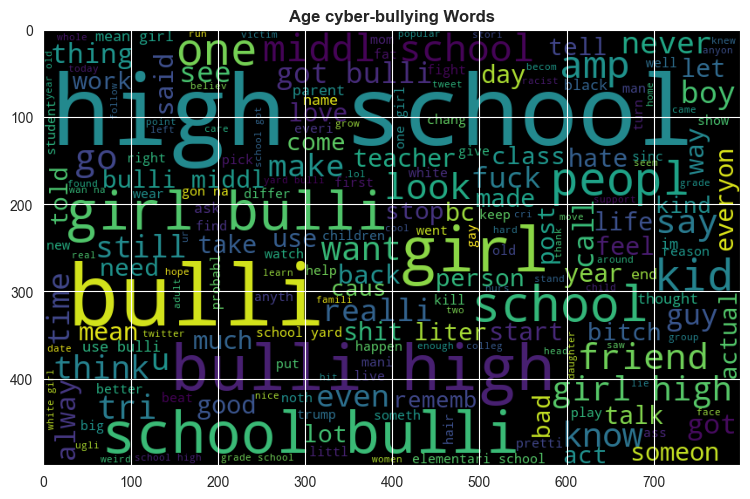

In [33]:
age_wordcloud = wc.generate(df[df['cyberbullying_type']=='age']['transformed_text'].str.cat(sep=""))
plt.figure(figsize=(9,7))
plt.imshow(age_wordcloud)
plt.title("Age cyber-bullying Words", fontweight='bold')
plt.show()

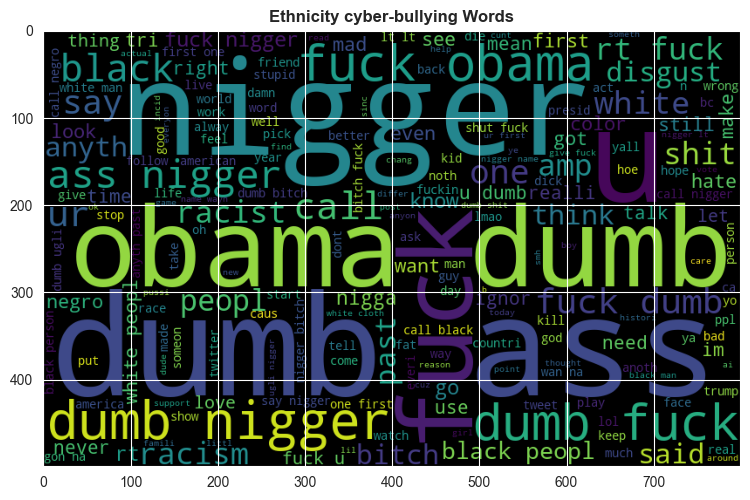

In [34]:
ethnicity_wordcloud = wc.generate(df[df['cyberbullying_type']=='ethnicity']['transformed_text'].str.cat(sep=""))
plt.figure(figsize=(9,7))
plt.imshow(ethnicity_wordcloud)
plt.title("Ethnicity cyber-bullying Words", fontweight='bold')
plt.show()

In [35]:
not_cyberbullying_corpus = []
for text in df[df['cyberbullying_type']=='not_cyberbullying']['transformed_text'].tolist():
    
    for word in text.split():
        not_cyberbullying_corpus.append(word)
        
not_cyberbullying_common_words = pd.DataFrame(Counter(not_cyberbullying_corpus).most_common(30), columns=['words', 'counts'])

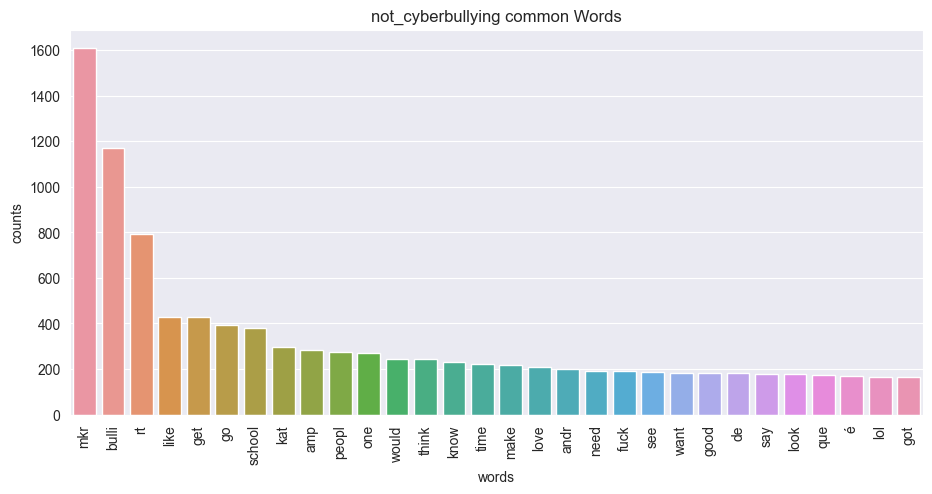

In [36]:
plt.figure(figsize=(11,5))
sns.barplot(x='words', y='counts', data=not_cyberbullying_common_words)
plt.title("not_cyberbullying common Words")
plt.xticks(rotation=90)
plt.show()

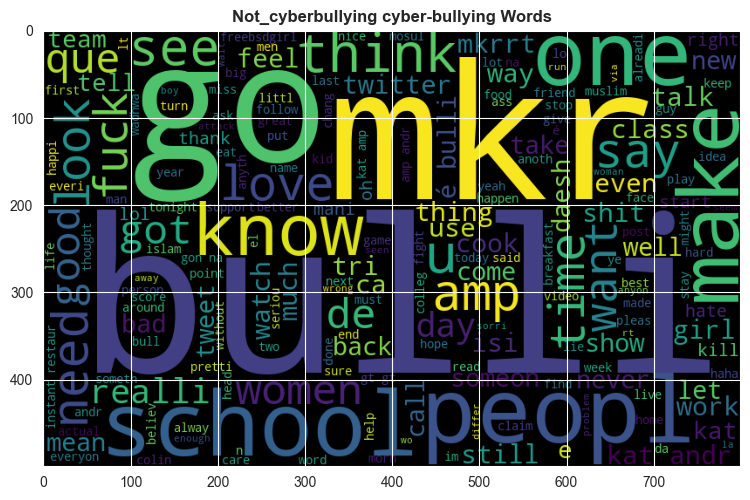

In [37]:
not_cyberbullying_wordcloud = wc.generate(df[df['cyberbullying_type']=='not_cyberbullying']['transformed_text'].str.cat(sep=""))
plt.figure(figsize=(9,7))
plt.imshow(not_cyberbullying_wordcloud)
plt.title("Not_cyberbullying cyber-bullying Words", fontweight='bold')
plt.show()

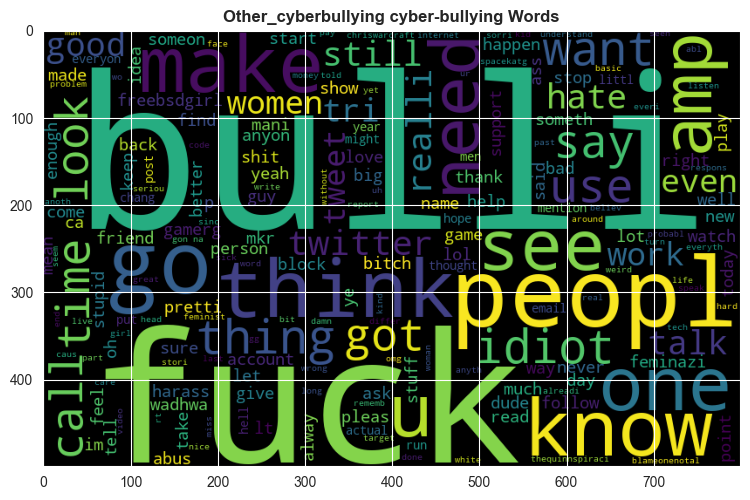

In [38]:
other_cyberbullying_wordcloud = wc.generate(df[df['cyberbullying_type']=='other_cyberbullying']['transformed_text'].str.cat(sep=""))
plt.figure(figsize=(9,7))
plt.imshow(other_cyberbullying_wordcloud)
plt.title("Other_cyberbullying cyber-bullying Words", fontweight='bold')
plt.show()

Data Partioning

In [39]:
x = df['transformed_text']
y = df['cyberbullying_type']

In [40]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [41]:
# Word embedding using TfIdf 
tfidf = TfidfVectorizer(max_features=3000)
X_train_arr = tfidf.fit_transform(X_train).toarray()
X_test_arr = tfidf.transform(X_test).toarray()

In [42]:
y_train.value_counts()

cyberbullying_type
religion               6435
gender                 6434
age                    6390
ethnicity              6323
not_cyberbullying      6313
other_cyberbullying    6229
Name: count, dtype: int64

In [43]:
# Encoding target feature
y_train_arr = y_train.map({'religion':0, 'gender':1, 'age':2, 'ethnicity':3, 'not_cyberbullying':4, 'other_cyberbullying':5})
y_test_arr = y_test.map({'religion':0, 'gender':1, 'age':2, 'ethnicity':3, 'not_cyberbullying':4, 'other_cyberbullying':5})

### Model Training

In [44]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_arr, y_train_arr)

y_pred = log_reg.predict(X_test_arr)
accuracy_score(y_test_arr, y_pred)

0.8253252203105329

In [45]:
# Gaussian Naive -bayes
gnb = GaussianNB()
gnb.fit(X_train_arr, y_train_arr)

y_pred = gnb.predict(X_test_arr)
accuracy_score(y_test_arr, y_pred)

0.5677717163239614

In [46]:
# Multinomial Naive-bayes
mnb = MultinomialNB()
mnb.fit(X_train_arr, y_train_arr)

y_pred = mnb.predict(X_test_arr)
accuracy_score(y_test_arr, y_pred)

0.7590222408728493

Among the models used, Logisitc Regression is performing the best. So, we will use that algorithm.

In [51]:
# Save model
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(log_reg, open('model.pkl', 'wb'))